<a href="https://colab.research.google.com/github/nuriamontala/PYT-SBI/blob/main/model_and_testing_11-04-2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FINAL AND CLEAN VERSION OF THE MODEL**

This Jupyter Notebook has the explained step-by-step code of how our deep graph neural network is defined and how it works.

**FEATURE EXTRACTION**

**GENERATING THE GRAPHS**

Here we should paste the code of how we used Graphein for generating the graphs of the proteins, and also talk about which functionalities we did include to generate the different types of edges


**OPEN GRAPHS FOLDER**

In [2]:
!unzip -o "/content/drive/MyDrive/MÁSTER/SBIPYTPLProject/protein_graphs.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/protein_graphs/4j79.pt  
  inflating: /content/protein_graphs/4j7i.pt  
  inflating: /content/protein_graphs/4j81.pt  
  inflating: /content/protein_graphs/4j82.pt  
  inflating: /content/protein_graphs/4j84.pt  
  inflating: /content/protein_graphs/4j86.pt  
  inflating: /content/protein_graphs/4j8b.pt  
  inflating: /content/protein_graphs/4j8g.pt  
  inflating: /content/protein_graphs/4j8s.pt  
  inflating: /content/protein_graphs/4j8t.pt  
  inflating: /content/protein_graphs/4jai.pt  
  inflating: /content/protein_graphs/4jaj.pt  
  inflating: /content/protein_graphs/4jaz.pt  
  inflating: /content/protein_graphs/4jbo.pt  
  inflating: /content/protein_graphs/4jbp.pt  
  inflating: /content/protein_graphs/4jbs.pt  
  inflating: /content/protein_graphs/4jc1.pt  
  inflating: /content/protein_graphs/4jck.pt  
  inflating: /content/protein_graphs/4jda.pt  
  inflating: /content/protein_graphs/4jdf.pt  
  inflati

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**GRAPH NEURAL NETWORK**



IMPORTS AND LIBRARIES

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GATConv
import pandas as pd
import os
import torch.nn.functional as F
from torch_scatter import scatter_mean, scatter_sum
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


torch, nn, F, optim: PyTorch for neural networks.

torch_geometric.*: para working with protein graphs

torch_scatter: for compulsory operations with virtual nodes.

sklearn.metrics: metrics for evaluating the binary classification.

os, pandas, numpy: datasets manipulation utilities.



DEFINITION OF AN EARLY STOPPING CLASS

This early stopping classed is used in the training for stopping it if the performance does not improve after some number of Epochs

In [ ]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

DEFINITION OF THE ProteinGraphDataset CLASS

This class is used for loading the data from the folder with all the graphs generated with graphein and that also contains the nodes with the features in order to train the model. Due to the fact that there exist much more residues labeled as non-binding sites that residues labeled as so, it also manages class imbalance.

In [ ]:
# Dataset class with statistics and class weight calculation
class ProteinGraphDataset(Dataset):
    def __init__(self, graph_folder, transform=None, pre_transform=None, pre_filter=None, cache_data=False):
        super().__init__(transform, pre_transform, pre_filter)
        self.graph_folder = graph_folder
        self.graph_files = [os.path.join(graph_folder, f) for f in os.listdir(graph_folder) if f.endswith(".pt")]

        # Optional caching for faster access
        self.cache_data = cache_data
        self._cache = {}

    def __len__(self):
        return len(self.graph_files)

    def __getitem__(self, idx):
        if self.cache_data and idx in self._cache:
            return self._cache[idx]

        try:
            data = torch.load(self.graph_files[idx])

            # Ensure batch attribute exists for virtual node implementation
            if not hasattr(data, 'batch') or data.batch is None:
                data.batch = torch.zeros(data.num_nodes, dtype=torch.long)

            # Apply any transforms
            if self.transform is not None:
                data = self.transform(data)

            # Cache if enabled
            if self.cache_data:
                self._cache[idx] = data

            return data
        except Exception as e:
            print(f"Error loading file {self.graph_files[idx]}: {e}")
            raise

    def get_class_weights(self):
        """Calculate class weights for handling imbalanced data."""
        all_labels = []
        for i in range(min(100, len(self))):  # Sample for efficiency
            data = self[i]
            all_labels.extend(data.y.tolist())

        # Count occurrences of each class
        label_counts = np.bincount(all_labels)
        n_samples = len(all_labels)
        n_classes = len(label_counts)

        # Weighted inversely proportional to class frequencies
        weights = n_samples / (n_classes * label_counts)
        return torch.FloatTensor(weights)

GRAPH ATTENTION CLASS

In the training of our graph neural network, we decided to implement this class in order to "take attention" to those features in the nodes being more important than the others.

In [ ]:
class FeatureAttention(nn.Module):
    def __init__(self, in_features):
        super(FeatureAttention, self).__init__()
        # Parámetros de atención por feature, inicializados a 1.0
        self.attn_weights = nn.Parameter(torch.ones(in_features))

    def forward(self, x):
        # x: [num_nodes, in_features]
        return x * self.attn_weights

CLASS OF GAT VIRTUAL NODE

Tu modelo principal, basado en:

GATConv: atención en grafos.

Nodo virtual: un nodo que resume toda la proteína y comunica con todos los nodos reales.

Residuos ↔ Nodo virtual ↔ Residuos: ida y vuelta de información.

Clasificador MLP: para predecir si cada nodo es sitio de unión (output binario).

Este bloque también guarda los pesos de atención para poder interpretar qué regiones fueron importantes.

In [ ]:
#Virtual Node GAT Model with proper message passing
class ImprovedGATVirtualNode(nn.Module):
    def __init__(self, in_features, hidden_dim, num_heads, num_classes, dropout=0.2,
                 residual=True, batch_norm=True):
        super(ImprovedGATVirtualNode, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.residual = residual
        self.batch_norm = batch_norm
        self.feature_attention = FeatureAttention(in_features)

        # Virtual node embedding
        self.virtual_node_embedding = nn.Parameter(torch.zeros(1, hidden_dim))

        # Virtual node update MLP
        self.virtual_node_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Graph Attention Layers
        self.gat1 = GATConv(in_features, hidden_dim // num_heads, heads=num_heads)
        self.gat2 = GATConv(hidden_dim, hidden_dim // num_heads, heads=num_heads)

        # Node-to-virtual message passing
        self.node_to_virtual = nn.Linear(hidden_dim, hidden_dim)

        # Virtual-to-node message passing
        self.virtual_to_node = nn.Linear(hidden_dim, hidden_dim)

        # MLP Classifier for node classification
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )

        # Optional BatchNorm layers
        if batch_norm:
            self.bn1 = nn.BatchNorm1d(hidden_dim)
            self.bn2 = nn.BatchNorm1d(hidden_dim)

        self.dropout = nn.Dropout(dropout)

        # Store attention weights for interpretability
        self.attention_weights = None

    def reset_parameters(self):
        """Reset all learnable parameters."""
        if hasattr(self, 'bn1'):
            self.bn1.reset_parameters()
            self.bn2.reset_parameters()

        self.gat1.reset_parameters()
        self.gat2.reset_parameters()

        # Reset virtual node embedding
        nn.init.zeros_(self.virtual_node_embedding)

        # Reset MLP layers
        for layer in self.virtual_node_mlp:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

        for layer in self.mlp:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

        self.node_to_virtual.reset_parameters()
        self.virtual_to_node.reset_parameters()

    def forward(self, data):

        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.feature_attention(x)


        # Ensure batch tensor exists
        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)

        # Get number of graphs in batch
        num_graphs = batch.max().item() + 1

        # Virtual node initial state
        virtual_node = self.virtual_node_embedding.expand(num_graphs, -1)

        # First GAT layer with attention weights capture
        x1, attention_weights1 = self.gat1(x, edge_index, return_attention_weights=True)
        x1 = F.relu(x1)

        if self.batch_norm:
            x1 = self.bn1(x1)

        x1 = self.dropout(x1)

        # Virtual node aggregation (nodes → virtual)
        virtual_node_temp = scatter_mean(self.node_to_virtual(x1), batch, dim=0)
        virtual_node = virtual_node + self.virtual_node_mlp(virtual_node_temp)

        # Virtual node messaging (virtual → nodes)
        virtual_node_features = self.virtual_to_node(virtual_node)[batch]

        # Add virtual node features to node embeddings
        x1 = x1 + virtual_node_features

        # Second GAT layer
        x2, attention_weights2 = self.gat2(x1, edge_index, return_attention_weights=True)

        # Store attention weights for interpretability
        self.attention_weights = (attention_weights1, attention_weights2)

        x2 = F.relu(x2)

        if self.batch_norm:
            x2 = self.bn2(x2)

        x2 = self.dropout(x2)

        # Residual connection if enabled
        if self.residual and x.size(1) == self.hidden_dim:
            x2 = x2 + x

        # Final node classification
        out = self.mlp(x2)

        return out

    def get_attention_weights(self):
        """Return attention weights for interpretability."""
        return self.attention_weights

CLASS IMPROVED EARLY STOPPING

Advanced version of the previous one which saves the best models and also computes some metrics

In [ ]:
# Improved Early Stopping with validation metrics monitoring
class ImprovedEarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=True, path='best_model.pt', metric_name='val_loss',
                 mode='min'):
        """
        Args:
            patience: Number of epochs with no improvement
            delta: Minimum change in monitored quantity to qualify as improvement
            verbose: If True, prints a message for each improvement
            path: Path to save the best model
            metric_name: Name of the metric to monitor
            mode: 'min' or 'max' (whether to minimize or maximize the metric)
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.path = path
        self.metric_name = metric_name
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

        # Set the appropriate comparison function
        self.improved = self._improvement_func()

    def _improvement_func(self):
        """Return the appropriate improvement function based on mode."""
        if self.mode == 'min':
            return lambda current, best: current < best - self.delta
        else:  # mode == 'max'
            return lambda current, best: current > best + self.delta

    def __call__(self, metrics, model):
        """
        Args:
            metrics: Dictionary of metrics
            model: Model to save
        """
        current = metrics[self.metric_name]

        if self.best_score is None:
            self.best_score = current
            self.save_checkpoint(metrics, model)
        elif not self.improved(current, self.best_score):
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = current
            self.save_checkpoint(metrics, model)
            self.counter = 0

    def save_checkpoint(self, metrics, model):
        """Save model when validation performance improves."""
        if self.verbose:
            print(f'Validation {self.metric_name} {"decreased" if self.mode == "min" else "increased"} '
                  f'({self.best_score:.6f} -> {metrics[self.metric_name]:.6f}). Saving model...')

        self.best_model_state = model.state_dict()
        torch.save(self.best_model_state, self.path)

    def load_best_model(self, model):
        """Load the best model."""
        model.load_state_dict(self.best_model_state)

CLASS FOR FOCAL LOSS OR CLASS IMBALANCCE

This class is used for penalizing more the errors in the minoritary classes (binding sites)

In [ ]:
# Focal Loss for handling class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        """
        Args:
            alpha: Weight factor for each class
            gamma: Focusing parameter
            reduction: 'none', 'mean', or 'sum'
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Args:
            inputs: Predicted logits (before softmax)
            targets: Ground truth labels
        """
        log_probs = F.log_softmax(inputs, dim=1)
        probs = torch.exp(log_probs)

        # Get probability for the correct class
        target_probs = probs.gather(1, targets.unsqueeze(1))
        target_probs = target_probs.squeeze(1)

        # Apply focusing parameter
        focal_weight = (1 - target_probs) ** self.gamma

        # Apply class weights if provided
        if self.alpha is not None:
            focal_weight = focal_weight * self.alpha[targets]

        loss = -focal_weight * log_probs.gather(1, targets.unsqueeze(1))
        loss = loss.squeeze(1)

        if self.reduction == 'none':
            return loss
        elif self.reduction == 'mean':
            return loss.mean()
        else:  # self.reduction == 'sum'
            return loss.sum()

**EVALUATION**

Evaluates your model on a dataset loader and computes comprehensive performance metrics, such as:

Accuracy, Precision, Recall, F1 score, AUC — standard classification metrics.

Loss — if a loss function is passed.

In [ ]:
# Comprehensive evaluation function
def evaluate_model(model, loader, device, criterion=None):
    """Comprehensive model evaluation with multiple metrics."""
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)

            # Forward pass
            out = model(data)

            # Compute loss if criterion is provided
            if criterion is not None:
                loss = criterion(out, data.y)
                total_loss += loss.item() * data.num_nodes

            # Get predictions and probabilities
            probs = F.softmax(out, dim=1)
            preds = out.argmax(dim=1)

            # Store predictions, labels, and scores
            all_preds.append(preds.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())
            all_scores.append(probs[:, 1].cpu().numpy())  # Probability of positive class

    # Concatenate results
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_scores = np.concatenate(all_scores)

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, zero_division=0),
        'recall': recall_score(all_labels, all_preds, zero_division=0),
        'f1': f1_score(all_labels, all_preds, zero_division=0),
        'auc': roc_auc_score(all_labels, all_scores) if len(np.unique(all_labels)) > 1 else 0.5
    }

    # Add loss if calculated
    if criterion is not None:
        metrics['loss'] = total_loss / len(all_labels)

    return metrics

**FEATURANCE IMPORTANCE ANALYSIS**

Estimates feature importance using gradient information.

It enables gradients on input features.

Computes the gradient of the output (positive class score) w.r.t. each input feature.

Averages gradients across batches.

Returns a sorted dictionary of feature names and their corresponding importance.

This is useful for interpreting what input features drive the predictions, helping with biological insights.



In [ ]:
# Feature importance analysis function
def analyze_feature_importance(model, loader, device, feature_names=None):
    """Analyze feature importance using gradient-based approach."""
    model.train()  # Need gradients
    feature_gradients = []

    for data in loader:
        data = data.to(device)

        # Enable gradients for input features
        data.x.requires_grad_(True)

        # Forward pass
        out = model(data)

        # Compute gradient w.r.t positive class score
        positive_class_score = out[:, 1].sum()
        positive_class_score.backward()

        # Store gradients
        feature_gradients.append(data.x.grad.abs().mean(dim=0).cpu().numpy())

        # Reset gradients
        data.x.grad = None

    # Average gradients across batches
    avg_gradients = np.mean(feature_gradients, axis=0)

    # Create feature importance dictionary
    if feature_names is None:
        feature_names = [f"Feature_{i}" for i in range(len(avg_gradients))]

    importance_dict = dict(zip(feature_names, avg_gradients))

    # Sort by importance
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

    return sorted_importance

**K-CROSS-FOLD VALIDATION**

Performs k-fold cross-validation on your dataset:

Splits data into k folds (e.g., 5).

Trains on k-1 folds and validates on the remaining fold.

For each fold:

Initializes the model.

Trains it with early stopping.

Evaluates performance on validation data.

Finally, it returns:

fold_results: metrics for each fold.

avg_results: average metrics across folds.

std_results: standard deviations (useful to assess variability).

In [ ]:
# K-fold cross-validation function
def kfold_cross_validation(dataset, model_class, model_kwargs, train_kwargs,
                           n_splits=5, seed=42, class_weights=None):
    """Perform k-fold cross-validation."""
    from sklearn.model_selection import KFold

    # Initialize k-fold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    # Get all indices
    indices = list(range(len(dataset)))

    # Store results
    fold_results = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(indices)):
        print(f"Fold {fold+1}/{n_splits}")

        # Create data loaders
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        test_subset = torch.utils.data.Subset(dataset, test_idx)

        train_loader = DataLoader(train_subset, batch_size=train_kwargs.get('batch_size', 8),
                                 shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=train_kwargs.get('batch_size', 8),
                                shuffle=False)

        # Initialize model
        model = model_class(**model_kwargs)

        # Train model
        # Implement your training function here
        # Define device
        device = train_kwargs.get('device', 'cuda' if torch.cuda.is_available() else 'cpu')

        # Define loss, optimizer, early stopping
        weights = class_weights
        criterion = FocalLoss(alpha=weights)
        optimizer = optim.Adam(model.parameters(), lr=train_kwargs.get('lr', 1e-3))
        early_stopping = ImprovedEarlyStopping(patience=5, path=f"best_model_fold{fold}.pt", metric_name='loss', mode='min')

        # Entrenar
        model = train_model(model, train_loader, test_loader, device, criterion, optimizer, early_stopping,
                            num_epochs=train_kwargs.get('num_epochs', 50))

        # Evaluate model
        metrics = evaluate_model(model, test_loader, train_kwargs.get('device'))

        fold_results.append(metrics)

        print(f"Fold {fold+1} results: {metrics}")

    # Calculate average results
    avg_results = {k: np.mean([r[k] for r in fold_results]) for k in fold_results[0].keys()}
    std_results = {k: np.std([r[k] for r in fold_results]) for k in fold_results[0].keys()}

    print(f"Average results: {avg_results}")
    print(f"Standard deviation: {std_results}")

    return fold_results, avg_results, std_results

**TRAINING LOOP**

In [ ]:
# Entrenamiento por épocas con validación y early stopping
def train_model(model, train_loader, val_loader, device, criterion, optimizer, early_stopping, num_epochs=50):
    """Entrena el modelo con validación y early stopping."""
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.num_nodes

        train_loss = total_loss / len(train_loader.dataset)

        # Evaluación en conjunto de validación
        val_metrics = evaluate_model(model, val_loader, device, criterion=criterion)
        print(f"Epoch {epoch+1:03d}: Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['loss']:.4f} | Val F1: {val_metrics['f1']:.4f}")

        # Aplicar early stopping
        early_stopping(val_metrics, model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    # Cargar el mejor modelo guardado
    early_stopping.load_best_model(model)
    return model
from sklearn.model_selection import train_test_split

**DATA SPLITTING AND MODEL CONFIGURATION**

In [ ]:
# 1️⃣ Cargar el dataset completo
dataset = ProteinGraphDataset("protein_graphs")

# 2️⃣ Dividir en training y test final
indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
final_test_dataset = torch.utils.data.Subset(dataset, test_indices)

# 3️⃣ Definir clases y parámetros del modelo
model_class = ImprovedGATVirtualNode
model_kwargs = {
    'in_features': 68,  # ajusta según tus features
    'hidden_dim': 64,
    'num_heads': 4,
    'num_classes': 2
}
train_kwargs = {
    'batch_size': 8,
    'lr': 1e-3,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_epochs': 50
}

class_weights = dataset.get_class_weights().to(train_kwargs["device"])

# 4️⃣ Validación cruzada en training set
print("🔁 Iniciando validación cruzada en el training set...")
cv_results, avg, std = kfold_cross_validation(train_dataset, model_class, model_kwargs, train_kwargs, class_weights=class_weights)
# 5️⃣ Entrenar modelo final con todo el training set
print("🚀 Entrenando modelo final con todo el training set...")
final_model = model_class(**model_kwargs).to(train_kwargs["device"])
weights = class_weights
criterion = FocalLoss(alpha=class_weights)
optimizer = optim.Adam(final_model.parameters(), lr=train_kwargs["lr"])
early_stopping = ImprovedEarlyStopping(patience=5, path="final_model.pt", metric_name='loss', mode='min')

final_model = train_model(
    final_model,
    DataLoader(train_dataset, batch_size=train_kwargs["batch_size"], shuffle=True),
    DataLoader(final_test_dataset, batch_size=train_kwargs["batch_size"], shuffle=False),
    train_kwargs["device"],
    criterion,
    optimizer,
    early_stopping,
    num_epochs=train_kwargs["num_epochs"]
)



FINAL TEST METRICS

In [ ]:
# 6️⃣ Evaluar en el test final (nunca usado antes)
print("🧪 Evaluando en el test final nunca visto...")
final_test_metrics = evaluate_model(
    final_model,
    DataLoader(final_test_dataset, batch_size=train_kwargs["batch_size"]),
    train_kwargs["device"]
)

print("\n🎯 Métricas en test final:")
for k, v in final_test_metrics.items():
    print(f"{k}: {v:.4f}")


import random

print("\n🔍 Mostrando predicciones de binding sites para 10 proteínas del test final:\n")

In [ ]:
# Seleccionar 10 índices aleatorios del conjunto de test
sample_indices = random.sample(range(len(final_test_dataset)), 10)

for i, idx in enumerate(sample_indices, 1):
    data = final_test_dataset[idx].to(train_kwargs["device"])
    model_output = final_model(data)
    predictions = model_output.argmax(dim=1).cpu().numpy()
    true_labels = data.y.cpu().numpy()

    predicted_binding_sites = [i for i, pred in enumerate(predictions) if pred == 1]
    true_binding_sites = [i for i, true in enumerate(true_labels) if true == 1]

    print(f"🧬 Proteína {i} (index {idx}):")
    print(f"   ✅ Sitios de unión reales:    {true_binding_sites}")
    print(f"   🔮 Sitios de unión predichos: {predicted_binding_sites}\n")

CLASSIFICATION OF PROTEINS

DEFINICIÓN DE NUESTRO MODELO ACTUAL

In [ ]:
import os
import requests
import csv

# Ruta a tu carpeta con los archivos .pt
folder_path = "protein_graphs"  # <-- Cambia esto a tu ruta real
output_csv = "pdb_classifications.csv"

def get_pdb_classification(pdb_code):
    url = f"https://data.rcsb.org/rest/v1/core/entry/{pdb_code.lower()}"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            return data.get("struct_keywords", {}).get("pdbx_keywords", "Unknown")
        else:
            return "Not Found"
    except Exception as e:
        return "Error"

def main():
    pdb_codes = [f[:-3] for f in os.listdir(folder_path) if f.endswith(".pt")]
    results = []

    print(f"Found {len(pdb_codes)} graph files.")

    for pdb in pdb_codes:
        classification = get_pdb_classification(pdb)
        print(f"{pdb}: {classification}")
        results.append((pdb, classification))

    with open(output_csv, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['pdb_code', 'classification'])
        writer.writerows(results)

    print(f"\n✅ CSV file saved to: {output_csv}")

if __name__ == "__main__":
    main()


Streaming output truncated to the last 5000 lines.
2jal: HYDROLASE
3zcz: HYDROLASE
5xbt: DNA BINDING PROTEIN
3qri: TRANSFERASE/TRANSFERASE INHIBITOR
4hev: HYDROLASE/HYDROLASE INHIBITOR
6jki: TRANSFERASE
2z9g: HYDROLASE
5npf: HYDROLASE
5elv: MEMBRANE PROTEIN
4dpf: Hydrolase/Hydrolase inhibitor
2fv9: HYDROLASE
4ifh: HYDROLASE/HYDROLASE INHIBITOR
5yy4: IMMUNE SYSTEM
4oex: HYDROLASE/HYDROLASE INHIBITOR
5ovi: SIGNALING PROTEIN
5e8a: SUGAR BINDING PROTEIN/INHIBITOR
5ef8: HYDROLASE/HYDROLASE INHIBITOR
4pgb: IMMUNE SYSTEM/PEPTIDE
3avm: RECOMBINATION/INHIBITOR
4gtq: TRANSFERASE/TRANSFERASE INHIBITOR
3km4: HYDROLASE/HYDROLASE INHIBITOR
4y2s: OXIDOREDUCTASE/OXIDOREDUCTASE INHIBITOR
2rip: HYDROLASE
1ag9: ELECTRON TRANSPORT
3otf: TRANSPORT PROTEIN
2f5t: TRANSCRIPTION
5nra: HYDROLASE
2o9k: GENE REGULATION
3fea: CELL CYCLE
1yid: LIGASE
3mj2: TRANSFERASE
6q6o: TRANSCRIPTION
4k9g: ISOMERASE
2ojf: TRANSFERASE
4x1f: GENE REGULATION
2yig: HYDROLASE
5gp7: TRANSFERASE
3eg6: PROTEIN BINDING
6cha: HYDROLASE (

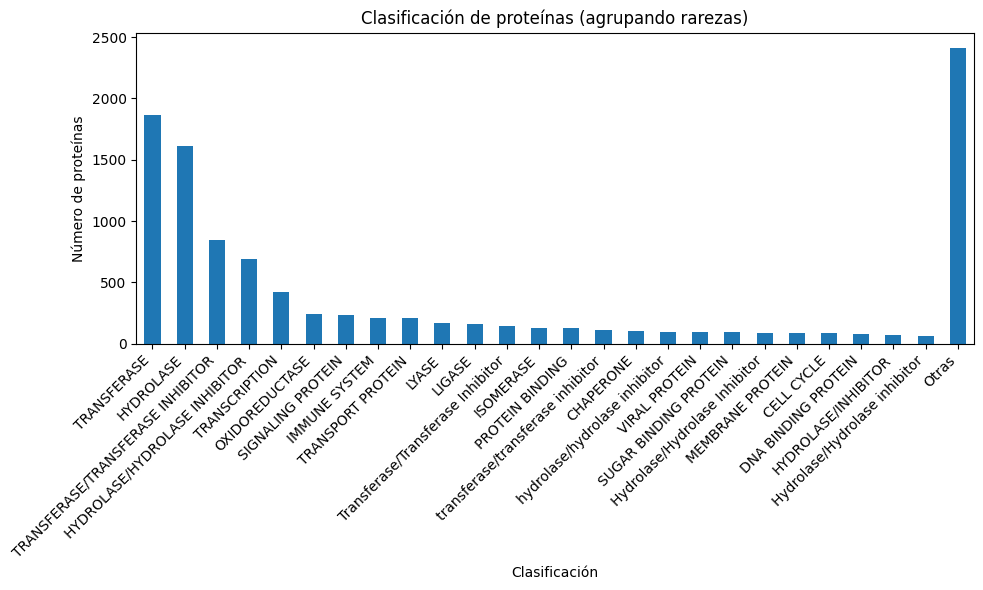

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ruta al CSV generado
csv_file = "pdb_classifications.csv"

# Leer el archivo
df = pd.read_csv(csv_file)

# Contar ocurrencias de cada clasificación
classification_counts = df['classification'].value_counts()

top_n = 25
top = classification_counts.head(top_n)
others_sum = classification_counts.iloc[top_n:].sum()
top["Otras"] = others_sum

plt.figure(figsize=(10, 6))
top.plot(kind='bar')
plt.title('Clasificación de proteínas (agrupando rarezas)')
plt.xlabel('Clasificación')
plt.ylabel('Número de proteínas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("classification_barplot_grouped.png")
plt.show()





In [5]:
# Uninstall current versions
!pip uninstall torch torch-scatter torch-sparse torch-geometric torch-cluster torch-spline-conv -y

# Install PyTorch 2.2.0 + CUDA 11.8
!pip install torch==2.2.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install PyTorch Geometric dependencies
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.2.0+cu118.html

# Finally, install torch-geometric and torch_geometric
!pip install torch-geometric
!pip install torch_geometric

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.7/811.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 110.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 6.4 MB/s eta 0:00:00
     ━━

NUEVO CÓDIGO PARA VISUALIZAR ESTRUCTURA 3D ADAM

Hay que instalar una librería: py3Dmol

In [5]:
!pip install py3Dmol

Para acceder a la gran cantidad de pdbs que tenemos, podemos hacer también mount de los pdbs


In [3]:
!unzip -o "/content/drive/MyDrive/MÁSTER/SBI_PYT_def/PDBs/pdb.zip" -d "/content/" #Path Adam. No canviar-lo, comentar la línea i afegir un nou baix

Streaming output truncated to the last 5000 lines.
  inflating: /content/pdb/protwithsitefinal/5lhg_protwithsite.pdb  
  inflating: /content/pdb/protwithsitefinal/5ov9_protwithsite.pdb  
  inflating: /content/pdb/protwithsitefinal/1h3a_protwithsite.pdb  
  inflating: /content/pdb/protwithsitefinal/6fmp_protwithsite.pdb  
  inflating: /content/pdb/protwithsitefinal/4aml_protwithsite.pdb  
  inflating: /content/pdb/protwithsitefinal/3dda_protwithsite.pdb  
  inflating: /content/pdb/protwithsitefinal/2v87_protwithsite.pdb  
  inflating: /content/pdb/protwithsitefinal/5vsd_protwithsite.pdb  
  inflating: /content/pdb/protwithsitefinal/2srt_protwithsite.pdb  
  inflating: /content/pdb/protwithsitefinal/4m3f_protwithsite.pdb  
  inflating: /content/pdb/protwithsitefinal/5ez0_protwithsite.pdb  
  inflating: /content/pdb/protwithsitefinal/6hdn_protwithsite.pdb  
  inflating: /content/pdb/protwithsitefinal/2qnb_protwithsite.pdb  
  inflating: /content/pdb/protwithsitefinal/4mnv_protwithsite.pdb

**PART FOR PREDICTING FROM INPUT pdb**

The first thing we will have to do

PACKAGES

BLAST AND DSSP

In [4]:
!sudo apt-get update
!sudo apt-get install -y dssp
!sudo apt-get install -y ncbi-blast+

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:4 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 Packages [34.3 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,243 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-update

HMMR

In [5]:
# 📦 Descargar y compilar HMMER (que incluye jackhmmer)
!wget http://eddylab.org/software/hmmer/hmmer.tar.gz
!tar -zxvf hmmer.tar.gz
!cd hmmer-3.* && ./configure && make && make install

--2025-04-11 10:50:18--  http://eddylab.org/software/hmmer/hmmer.tar.gz
Resolving eddylab.org (eddylab.org)... 96.126.110.11, 2600:3c03::f03c:91ff:fec8:383c
Connecting to eddylab.org (eddylab.org)|96.126.110.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19669667 (19M) [application/x-gzip]
Saving to: ‘hmmer.tar.gz’

hmmer.tar.gz        100%[===================>]  18.76M  14.9MB/s    in 1.3s    

2025-04-11 10:50:20 (14.9 MB/s) - ‘hmmer.tar.gz’ saved [19669667/19669667]

hmmer-3.4/
hmmer-3.4/documentation/
hmmer-3.4/install-sh
hmmer-3.4/configure.ac
hmmer-3.4/tutorial/
hmmer-3.4/INSTALL
hmmer-3.4/libdivsufsort/
hmmer-3.4/LICENSE
hmmer-3.4/test-speed/
hmmer-3.4/configure
hmmer-3.4/testsuite/
hmmer-3.4/RELEASE-3.4.md
hmmer-3.4/config.guess
hmmer-3.4/README.md
hmmer-3.4/Userguide.pdf
hmmer-3.4/config.sub
hmmer-3.4/.gitignore
hmmer-3.4/profmark/
hmmer-3.4/makeTAGS.sh
hmmer-3.4/easel/
hmmer-3.4/Makefile.in
hmmer-3.4/.travis.yml
hmmer-3.4/src/
hmmer-3.4/src/itest_

BIO

In [6]:
!pip install Bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.6 MB/s eta 0:00:00


NUMPY

In [7]:
!pip install numpy==1.23.5 --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 49.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, b

GRAPHEIN

In [1]:
pip install graphein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.0/316.0 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

LOAD THE SAVED MODEL

**GET FASTA SEQUENCES FROM A PDB**

Reads the SEQRES records from a PDB file.

Converts the 3-letter amino acid codes to 1-letter codes.

Filters chains shorter than min_length or if max_chains is exceeded.

Saves each chain as a separate .fa FASTA file.

In [2]:
import os

def pdb2fasta(pdb_id, pdb_directory, fasta_directory, min_length=30, max_chains=6):
    """Extract protein sequence from a PDB file and save it as FASTA in the fasta directory."""

    res_dict = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
               'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
               'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
               'ALA': 'A', 'VAL': 'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

    os.makedirs(fasta_directory, exist_ok=True)

    pdb_file = os.path.join(pdb_directory, f"{pdb_id}.pdb")

    # Dictionary to store all sequences
    chain_dict = {}

    # Read sequence from SEQRES section in the PDB
    with open(pdb_file, "r") as f:
        for line in f:
            if line.startswith("SEQRES"):
                parts = line.split()
                chain_id=pdb_id+"_"+parts[2]
                # Convert 3-letter code to 1-letter
                seq = [res_dict.get(res, "X") for res in parts[4:]]
                if chain_id in chain_dict:
                    chain_dict[chain_id] += "".join(seq)
                else:
                    chain_dict[chain_id] = "".join(seq)

    num_chains = len(chain_dict)
    if num_chains > max_chains:
        raise Exception(f"Skipping PDB. File has {num_chains} chains (limit: {max_chains})")
    # Filter short chains and save in FASTA
    final_dict = {key: seq for key, seq in chain_dict.items() if len(seq) > min_length}

    for chain_id, sequence in final_dict.items():
        fasta_file = os.path.join(fasta_directory, f"{chain_id}.fa")
        with open(fasta_file, "w") as f:
            f.write(f">{chain_id}\n{sequence}\n")
        print(f"FASTA saved: {fasta_file}")

    return final_dict

**SEQUENCE OFFSETS ESTIMATIONS**

In [5]:
def get_offset_from_pdb(pdb_id, pdb_directory):
    """Extract offsets per chain from PDB file. Return a dictionary {chain_id: offset}."""

    pdb_file = os.path.join(pdb_directory, f"{pdb_id}.pdb")

    offset_per_chain = {}
    first_missing_per_chain = {}
    first_atom_per_chain = {}

    with open(pdb_file, "r") as f:
        for line in f:
            parts = line.split()

            if line.startswith("REMARK 465") and len(parts) == 5:
                _, _, resname, chain, res_id = parts
                try:
                    chain_id=pdb_id+"_"+chain
                    res_id = int(res_id)
                    if chain_id not in first_missing_per_chain:
                        first_missing_per_chain[chain_id] = res_id
                except ValueError:
                    pass

            elif line.startswith("ATOM"):
                try:
                    res_id = int(line[22:26].strip())
                    chain = line[21]
                    chain_id=pdb_id+"_"+chain
                    if chain_id not in first_atom_per_chain:
                        first_atom_per_chain[chain_id] = res_id
                except ValueError:
                    pass

    for chain_id in set(first_missing_per_chain) | set(first_atom_per_chain):
        first_res_id = min(
            first_missing_per_chain.get(chain_id, float('inf')),
            first_atom_per_chain.get(chain_id, float('inf'))
        )
        offset_per_chain[chain_id] = first_res_id - 1

    return offset_per_chain

**GET BINDING SITES**

Reads SITE records from modified PDB files.

Returns a dictionary marking each residue as:

1 → part of a binding site.

0 → not a binding site.

In [6]:
def get_binding_sites(pdb_id, pdb_site_directory):
    """Parse edited PDB files and return a dictionary labeling binding site residues."""

    res_dict = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
               'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
               'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
               'ALA': 'A', 'VAL': 'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

    pdb_file = os.path.join(pdb_site_directory, f"{pdb_id}_protwithsite.pdb")
    binding_data = {}

    with open(pdb_file, "r") as f:
        for line in f:
            if line.startswith("ATOM") or line.startswith("SITE"):
                try:
                    res_id = int(line[22:26].strip())
                    chain = line[21]
                    res_name = line[17:20].strip()
                    if line.startswith("SITE"):
                        binding_data[(res_id, chain, res_dict[res_name])] = [1]
                    elif (res_id, chain) not in binding_data:
                        binding_data[(res_id, chain, res_dict[res_name])] = [0]

                except ValueError:
                    pass
    return binding_data

**DEFINE PSYCOCHEMICAL FEATURES**

Uses Bio.PDB to parse the structure.

For each residue with a Cα atom:

Retrieves its physicochemical properties from a dictionary.

Adds the B-factor of the Cα atom.

In [7]:
from Bio.PDB import PDBParser

def get_physicochemical_features(pdb_id, pdb_directory):
    """Extract physicochemical properties and B-factor for each residue in a PDB file."""
    AA_PROPERTIES = {
        "ALA": [1.24, 0.62, 0.38, 6.00],
        "ARG": [2.74, -2.53, 0.89, 10.76],
        "ASN": [2.14, -0.78, 0.48, 5.41],
        "ASP": [2.16, -0.90, 0.49, 2.85],
        "CYS": [1.50, 0.29, 0.54, 5.07],
        "GLN": [2.17, -0.85, 0.51, 5.65],
        "GLU": [2.18, -0.74, 0.52, 3.15],
        "GLY": [0.00, 0.48, 0.00, 6.06],
        "HIS": [2.48, -0.40, 0.69, 7.60],
        "ILE": [3.08, 1.25, 0.76, 6.05],
        "LEU": [2.80, 1.22, 0.74, 6.01],
        "LYS": [2.90, -2.25, 0.84, 9.74],
        "MET": [2.67, 1.02, 0.72, 5.74],
        "PHE": [2.58, 1.47, 0.78, 5.48],
        "PRO": [1.95, 0.09, 0.64, 6.30],
        "SER": [1.31, -0.28, 0.41, 5.68],
        "THR": [1.50, -0.18, 0.44, 5.60],
        "TRP": [3.07, 1.45, 0.81, 5.89],
        "TYR": [2.67, 0.94, 0.76, 5.64],
        "VAL": [2.50, 1.08, 0.71, 6.00]
        }

    res_dict = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
               'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
               'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
               'ALA': 'A', 'VAL': 'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

    pdb_file = f"{pdb_directory}/{pdb_id}.pdb"
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    model = structure[0]

    physicochemical_data = {}

    for chain in model:
        chain_id = chain.id
        for residue in chain:
             # Only standard aminoacids with Cα
            if residue.id[0] == " " and "CA" in residue:
                res_id = residue.id[1]
                res_name = residue.resname
                b_factor = residue["CA"].bfactor
                features = AA_PROPERTIES.get(res_name, [0.0] * 7) + [b_factor]
                physicochemical_data[(res_id, chain_id, res_dict[res_name])] = features
    return physicochemical_data

**RUN PSIBLAST AND JACKHAMMR**

In [8]:
import os
import subprocess
import glob
import shutil
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def run_psiblast(chain_dictionary, db, fasta_directory, psiblast_directory, num_iterations=3, evalue=0.001):
    """Run PSI-BLAST on unique sequences and copy results for duplicate chains."""

    os.makedirs(psiblast_directory, exist_ok=True)
    # Initialise a dictionary which is reversed from the input dictionary: when executing PSI-BlLAST, key will be sequence and value will be chain_id
    processed_sequences = {}

    for chain_id, sequence in chain_dictionary.items():
        query_fasta = f"{fasta_directory}/{chain_id}.fa"
        out_pssm = f"{psiblast_directory}/{chain_id}.pssm"

        if sequence in processed_sequences:
            # If PSI-BLAST already done for this sequence, copy PSSM file
            existing_pssm = f"{psiblast_directory}/{processed_sequences[sequence]}.pssm"
            shutil.copy(existing_pssm, out_pssm)
            print(f"Copied PSSM from {processed_sequences[sequence]} to {chain_id}")
        else:
            # Execute PSI-BLAST for new sequence
            cmd = [
                "psiblast",
                "-query", query_fasta,
                "-db", db,
                "-num_iterations", str(num_iterations),
                "-num_threads", "6",
                "-evalue", str(evalue),
                "-out_ascii_pssm", out_pssm,
                "-outfmt", "0"
            ]
            with open(os.devnull, 'w') as devnull:
                try:
                    subprocess.run(cmd, check=True, stdout=devnull, stderr=devnull)
                    print(f"PSI-BLAST completed for {chain_id}. PSSM saved to {out_pssm}")
                    # Add proccessed chain_id to the dictionary with its sequence as the key
                    processed_sequences[sequence] = chain_id
                except subprocess.CalledProcessError as e:
                    print(f"Error running PSI-BLAST for {chain_id}: {e}")

def run_jackhmmer(chain_dictionary, db, fasta_directory, jackhmmr_directory, num_iterations=5):
    """Run jackhmmer and save the final model in jackhmmr directory."""

    os.makedirs(jackhmmr_directory, exist_ok=True)

    # Initialise a dictionary which is reversed from the input dictionary: when executing PSI-BlLAST, key will be sequence and value will be chain_id
    processed_sequences = {}

    for chain_id, sequence in chain_dictionary.items():
        query_fasta = f"{fasta_directory}/{chain_id}.fa"
        out_hmm = f"{jackhmmr_directory}/{chain_id}.hmm"

        if sequence in processed_sequences:
            # If jackhmmr already done for this sequence, copy PSSM file
            existing_hmm = f"{jackhmmr_directory}/{processed_sequences[sequence]}.hmm"
            shutil.copy(existing_hmm, out_hmm)
            print(f"Copied HMM from {processed_sequences[sequence]} to {chain_id}")
        else:
            # Execute jackhmmr for new sequence
            cmd = [
                "jackhmmer",
                "-N", str(num_iterations),
                "--chkhmm", f"{jackhmmr_directory}/model",
                "--cpu", "6",
                query_fasta,
                db
            ]
            with open(os.devnull, 'w') as devnull:
                try:
                    subprocess.run(cmd, check=True, stdout=devnull, stderr=devnull)
                    # Search for latest model
                    hmm_files = glob.glob(f"{jackhmmr_directory}/model-*.hmm")
                    if hmm_files:
                        latest_model = max(hmm_files, key=lambda x: int(x.split('-')[-1].split('.')[0]))
                        final_hmm_path = f"{jackhmmr_directory}/{chain_id}.hmm"
                        os.rename(latest_model, final_hmm_path)

                        # Delete temp files model-*.hmm
                        for hmm_file in hmm_files:
                            try:
                                os.remove(hmm_file)
                            except FileNotFoundError:
                                pass
                        print(f"jackhmmer completed successfully. Model saved to {final_hmm_path}")
                        processed_sequences[sequence] = chain_id
                    else:
                        print("No HMM model files found.")
                except subprocess.CalledProcessError as e:
                    print(f"Error running jackhmmer: {e}")

**LOAD PSSM and HMM FILES**

In [9]:
def parse_pssm(chain_dictionary, psiblast_directory, offset_per_chain):
    """Parse the PSSM file and return a dictionary with residue indices as keys and PSSM values as lists."""
    pssm_data = {}
    for chain_id, _ in chain_dictionary.items():
        pssm_file=f"{psiblast_directory}/{chain_id}.pssm"
        start = False
        with open(pssm_file) as f:
            lines = f.readlines()
            for line in lines:
                if line.strip().startswith("A"):
                    start = True
                    continue
                if start:
                    scoreList=line.split()
                    if len(scoreList) < 20:
                        break
                    offset=offset_per_chain[chain_id]
                    res_id=int(scoreList[0])+offset
                    res_name = scoreList[1]
                    scores = list(map(int, scoreList[0:22][2:]))
                    sigmoid_scores=[sigmoid(s) for s in scores]
                    pssm_data[(res_id, chain_id.split("_")[1], res_name)] = sigmoid_scores
    return pssm_data

def parse_hmm(chain_dictionary, jackhmmr_directory, offset_per_chain):
    """Parse the HMM file and return a dictionary with residue indices as keys and HMM probabilities."""
    hmm_data = {}
    for chain_id, sequence in chain_dictionary.items():
        hmm_file=f"{jackhmmr_directory}/{chain_id}.hmm"
        reading = False
        emissions = None
        with open(hmm_file) as f:
            for line in f:
                if line.startswith("HMM "):
                    reading = True
                    continue
                if reading:
                    scores = line.split()
                    if len(scores)==26:
                        hmm_index = int(scores[0]) - 1
                        offset=offset_per_chain[chain_id]
                        res_id=hmm_index + 1 + offset
                        res_name=sequence[hmm_index]
                        emissions = [float(s) for s in scores[1:21]]
                    if len(scores)==7 and not scores[0].startswith("m->"):
                        transitions = [0.0 if s == '*' else float(s) for s in scores]
                        if emissions and transitions:
                            hmm_data[(res_id, chain_id.split("_")[1], res_name)]=emissions+transitions
                            emissions=None
    return hmm_data

column_names = (
    ["prop1","prop2","prop3","prop4", "b_factor"]
    + ["sin_phi", "cos_phi", "sin_psi", "cos_psi", "H", "B", "E", "G", "I", "T", "S", "-", "ASA", "HSE_up", "HSE_down", "CN"]
    + ["PSSM_" + str(i) for i in range(1,21)]
    + ["HMM_" + str(i) for i in range(1,28)]
    + ["binding_site"]
)

from Bio.PDB import PDBParser, DSSP, HSExposureCB, NeighborSearch
import numpy as np

**GET STRUCTURAL FEATURES**

Uses Bio.PDB + DSSP and HSExposureCB to extract:

Torsion angles (phi, psi)

Solvent accessibility (ASA)

Secondary structure (SS)

Half Sphere Exposure (HSE)

Contact number (CN)

Formats them into a dictionary by residue.

In [10]:
from Bio.PDB import PDBParser, DSSP, HSExposureCB, NeighborSearch
import numpy as np

def get_structural_features(pdb_id, pdb_directory):
    """Extract structural features from a PDB file and save to a CSV file."""

    res_dict = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
               'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
               'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
               'ALA': 'A', 'VAL': 'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

    pdb_file = f"{pdb_directory}/{pdb_id}.pdb"

    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_id, pdb_file)
    model = structure[0]

    # Load DSSP (ASA and secondary structure)
    import shutil

    dssp_exe = shutil.which("mkdssp") or shutil.which("dssp")
    if not dssp_exe:
        raise RuntimeError("❌ DSSP (mkdssp) no encontrado. Asegúrate de haberlo instalado con `apt install dssp`.")

    dssp = DSSP(model, pdb_file, dssp=dssp_exe)

    # Compute Half Sphere Exposure
    hse = HSExposureCB(model)

    # Get all Cα for Contact Number (CN)
    ca_atoms = [residue['CA'] for chain in model for residue in chain if 'CA' in residue]
    ns = NeighborSearch(ca_atoms)

    structural_data={}

    for chain in model:
        for residue in chain:
            chain_id = chain.id
            res_id = residue.id[1]
            res_name = residue.resname
            if residue.id[0] == " " and (chain_id, res_id) in dssp:
                # Torsional angles phi y psi (sinus and cosinus)
                phi = np.radians(dssp[(chain.id, res_id)][4])
                psi = np.radians(dssp[(chain.id, res_id)][5])
                if phi is None or psi is None:
                    sin_phi, cos_phi, sin_psi, cos_psi = 0.0, 0.0, 0.0, 0.0
                else:
                    phi, psi = np.radians(phi), np.radians(psi)
                    sin_phi, cos_phi = np.sin(phi), np.cos(phi)
                    sin_psi, cos_psi = np.sin(psi), np.cos(psi)
                # Solvent Accessibility ASA
                asa = dssp[(chain.id, res_id)][3]

                # Secondary Structure
                ss=dssp[(chain_id,res_id)][2]

                # Half Sphere Exposure (HSE)
                key = (chain.id, residue.id)  # Esto es ('A', (' ', 1, ' '))
                if key in hse:
                    hse_values = hse[key]
                else:
                    print(f"Residue {key} not found in HSE")
                    continue

                # Contact Number (CN)
                cn = "NA"
                if 'CA' in residue:
                    ca_atom = residue['CA']
                    neighbors = ns.search(ca_atom.coord, 10.0)
                    cn = len(neighbors) - 1

                data_list=[sin_phi, cos_phi, sin_psi, cos_psi,
                    1 if ss == "H" else 0,
                    1 if ss == "B" else 0,
                    1 if ss == "E" else 0,
                    1 if ss == "G" else 0,
                    1 if ss == "I" else 0,
                    1 if ss == "T" else 0,
                    1 if ss == "S" else 0,
                    1 if ss == "-" else 0,
                    asa, hse_values[0], hse_values[1], cn]
                structural_data[(res_id,chain_id, res_dict[res_name])]=data_list
    return structural_data

**PROCESSING THE INPUT FILE**

In [12]:
cd /content/pdb/original_files/

/content/pdb/original_files


In [17]:
import os
import pandas as pd
import shutil
from pathlib import Path

# CONFIG
PDB_ID = "1anf"
PDB_PATH = f"/content/pdb/original_files/{PDB_ID}.pdb"
FASTA_DIR = "fasta"
PSIBLAST_DIR = "psiblast"
JACKHMMER_DIR = "jackhmmer"
FEATURES_DIR = "features"
NORMALIZED_DIR = "normalized_features"
DB_DIR = "database"
PSIBLAST_DB = os.path.join(DB_DIR, "uniprot_sprot_db")
JACKHMMER_DB = os.path.join(DB_DIR, "uniprot_sprot.fasta")
MINMAX_PATH = "global_min_max.csv"

# CREATE FOLDERS
for path in [FASTA_DIR, PSIBLAST_DIR, JACKHMMER_DIR, FEATURES_DIR, NORMALIZED_DIR]:
    os.makedirs(path, exist_ok=True)

print(f"⏳ Procesando {PDB_ID}...")

# 1. FASTA
chain_dict = pdb2fasta(PDB_ID, ".", FASTA_DIR)

# 2. Offsets
offset_per_chain = get_offset_from_pdb(PDB_ID, ".")

# 3. Features
physchem_data = get_physicochemical_features(PDB_ID, ".")
structural_data = get_structural_features(PDB_ID, ".")
run_psiblast(chain_dict, PSIBLAST_DB, FASTA_DIR, PSIBLAST_DIR)
run_jackhmmer(chain_dict, JACKHMMER_DB, FASTA_DIR, JACKHMMER_DIR)
pssm_data = parse_pssm(chain_dict, PSIBLAST_DIR, offset_per_chain)
hmm_data = parse_hmm(chain_dict, JACKHMMER_DIR, offset_per_chain)

# 4. Combine features only for residues present in all sources
all_keys = set(physchem_data) & set(structural_data) & set(pssm_data) & set(hmm_data)

rows = []
for key in all_keys:
    row = []
    row.extend(physchem_data.get(key, [0.0]*5))
    row.extend(structural_data.get(key, [0.0]*15))
    row.extend(pssm_data.get(key, [0.0]*20))
    row.extend(hmm_data.get(key, [0.0]*27))
    row.append(0)  # Placeholder for binding_site (0 = unknown)
    if len(row) != len(column_names):
        print(f"❌ Skipping residue {key}: feature length mismatch")
        continue
    rows.append([key] + row)

df = pd.DataFrame(rows, columns=["residue_id"] + column_names)
raw_csv_path = os.path.join(FEATURES_DIR, f"{PDB_ID}.csv")
df.to_csv(raw_csv_path, index=False)
print(f"✅ CSV sin normalizar guardado en: {raw_csv_path}")

# 5. Normalize using global min-max
min_max_df = pd.read_csv(MINMAX_PATH, sep="\t", names=["index", "Min", "Max"], header=0)
min_max_df = min_max_df.set_index("index")


norm_df = df.copy()

features_to_normalize = [f for f in column_names[:-1] if not f.startswith("PSSM_")]

for feature in features_to_normalize:  # Exclude 'binding_site'
    if feature not in min_max_df.index:
        print(f"⚠️ Feature {feature} no está en el archivo de min-max. Saltando.")
        norm_df[feature] = 0.0
        continue

    min_val = min_max_df.loc[feature, "Min"]
    max_val = min_max_df.loc[feature, "Max"]

    if max_val - min_val > 1e-6:
        norm_df[feature] = (norm_df[feature] - min_val) / (max_val - min_val)
    else:
        norm_df[feature] = 0.0

normalized_path = os.path.join(NORMALIZED_DIR, f"{PDB_ID}.csv")
norm_df.to_csv(normalized_path, index=False)
print(f"✅ CSV normalizado guardado en: {normalized_path}")

⏳ Procesando 1anf...
FASTA saved: fasta/1anf_A.fa
Error running PSI-BLAST for 1anf_A: Command '['psiblast', '-query', 'fasta/1anf_A.fa', '-db', 'database/uniprot_sprot_db', '-num_iterations', '3', '-num_threads', '6', '-evalue', '0.001', '-out_ascii_pssm', 'psiblast/1anf_A.pssm', '-outfmt', '0']' returned non-zero exit status 2.
Error running jackhmmer: Command '['jackhmmer', '-N', '5', '--chkhmm', 'jackhmmer/model', '--cpu', '6', 'fasta/1anf_A.fa', 'database/uniprot_sprot.fasta']' returned non-zero exit status 1.


FileNotFoundError: [Errno 2] No such file or directory: 'psiblast/1anf_A.pssm'

**GENERATE GRAPH AND CONVERT IT TO PYTORCH GEOMETRIC**

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.graphs import construct_graph
from torch_geometric.data import Data
import ast

from graphein.protein.edges.distance import (
    add_peptide_bonds, add_hydrogen_bond_interactions,
    add_disulfide_interactions, add_ionic_interactions,
    add_aromatic_interactions, add_aromatic_sulphur_interactions,
    add_cation_pi_interactions, add_delaunay_triangulation
)

# ➕ Funciones de construcción de aristas
new_edge_funcs = {
    "edge_construction_functions": [
        add_peptide_bonds,
        add_aromatic_interactions,
        add_hydrogen_bond_interactions,
        add_disulfide_interactions,
        add_ionic_interactions,
        add_aromatic_sulphur_interactions,
        add_cation_pi_interactions,
        add_delaunay_triangulation
    ]
}

# 🔁 Diccionario 3-letter → 1-letter
three_to_one = {
    'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D',
    'CYS': 'C', 'GLU': 'E', 'GLN': 'Q', 'GLY': 'G',
    'HIS': 'H', 'ILE': 'I', 'LEU': 'L', 'LYS': 'K',
    'MET': 'M', 'PHE': 'F', 'PRO': 'P', 'SER': 'S',
    'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V',
    'SEC': 'U', 'PYL': 'O', 'ASX': 'B', 'GLX': 'Z',
    'XLE': 'J', 'UNK': 'X'
}

def load_residue_features(csv_path):
    df = pd.read_csv(csv_path)

    # Parsear residuo_id a tupla
    df["residue_id"] = df["residue_id"].apply(ast.literal_eval)

    residue_ids = df["residue_id"]
    features = df.iloc[:, 1:-1].values
    labels = df.iloc[:, -1].values

    features_dict = {res_id: feat for res_id, feat in zip(residue_ids, features)}
    labels_dict = {res_id: label for res_id, label in zip(residue_ids, labels)}

    return features_dict, labels_dict, features.shape[1]

def networkx_to_pyg(G_nx, features_dict, labels_dict, num_features):
    node_map = {}
    reverse_map = {}
    node_features = []
    y = []
    valid_nodes = set()

    for i, (node, attr) in enumerate(G_nx.nodes(data=True)):
        res_name_3 = attr.get("residue_name")
        res_name_1 = three_to_one.get(res_name_3, 'X')
        res_id = (attr.get("residue_number"), attr.get("chain_id"), res_name_1)

        if res_id not in features_dict:
            print(f"⚠️ Residuo {res_id} sin features, se omite.")
            continue

        valid_nodes.add(node)
        node_map[node] = len(node_features)
        reverse_map[len(node_features)] = res_id

        node_features.append(features_dict[res_id])
        y.append(labels_dict.get(res_id, 0))

    if not node_features:
        print("❌ Sin nodos válidos.")
        return None, None

    x = torch.tensor(np.array(node_features), dtype=torch.float)
    y = torch.tensor(y, dtype=torch.long)

    edges = [
        (node_map[u], node_map[v])
        for u, v in G_nx.edges()
        if u in valid_nodes and v in valid_nodes
    ]

    if not edges:
        print("❌ No se generaron aristas válidas.")
        return None, None

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index, y=y), reverse_map


# === MAIN ===
pdb_path = "1a3n.pdb"
csv_path = "normalized_features/1a3n.csv"
save_path = "graphs/1a3n.pt"


# Cargar features
features_dict, labels_dict, num_features = load_residue_features(csv_path)

# Construir grafo NetworkX
config = ProteinGraphConfig(**new_edge_funcs)
G_nx = construct_graph(config=config, path=pdb_path)

# Convertir a PyG
protein_graph_data, reverse_map = networkx_to_pyg(G_nx, features_dict, labels_dict, num_features)


# Guardar grafo
if protein_graph_data is not None:
    dir_name = os.path.dirname(save_path)
    if dir_name:
        os.makedirs(dir_name, exist_ok=True)
    torch.save((protein_graph_data, reverse_map), save_path)
    print(f"✅ Grafo guardado en {save_path}")
else:
    print("❌ No se generó el grafo.")

**LOAD THE GRAPH**

In [ ]:
from torch_geometric.data import Data
import torch.nn.functional as F

# Cargar grafo + reverse_map
graph_path = "graphs/1a3n.pt"
data, reverse_map = torch.load(graph_path, weights_only=False)
data.batch = torch.zeros(data.num_nodes, dtype=torch.long)

assert data.x.shape[1] == 68, "❌ El número de features no coincide con el modelo"

# Cargar modelo
model = ImprovedGATVirtualNode(
    in_features=68,
    hidden_dim=64,
    num_heads=4,
    num_classes=2
)

# Cargar pesos entrenados
model.load_state_dict(torch.load("best_model_fold3.pt", map_location=torch.device("cpu")))
model.eval()


# Continuar con device y predicción
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

# Predicción
with torch.no_grad():
    logits = model(data)
    probs = F.softmax(logits, dim=1)
    threshold = 0.5
    preds = (probs[:, 1] >= threshold).long()

# Mostrar resultados con residuo real
print(f"🔍 Binding site predictions (threshold = {threshold}):")
for idx in range(len(preds)):
    if preds[idx] == 1:
        res_id = reverse_map.get(idx, f"Node_{idx}")
        print(f"✅ Residue {res_id}: Prob = {probs[idx, 1].item():.4f}")

**MAIN EXECUTION BLOCK?**

In [ ]:
# ✅ Main execution block
if __name__ == "__main__":
    # Set paths
    model_path = "trained_gat_model.pth"
    pdb_file = "6afj.pdb"  # Example PDB file
    csv_file = "6afj.csv"  # Example CSV file with features
    output_dir = "prediction_results"

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")

    # Load model dynamically
    try:
        # First load feature size from CSV
        features_dict, num_features = load_residue_features(csv_file)

        if num_features == 0:
            logger.error("Could not determine input feature size. Exiting.")
            import sys
            sys.exit(1)

        # Check if improved model class exists in the environment
        if 'ImprovedGATVirtualNode' in globals():
            # Initialize improved model
            model = ImprovedGATVirtualNode(
                in_features=num_features,
                hidden_dim=128,
                num_heads=4,
                num_classes=2,
                dropout=0.2,
                residual=True,
                batch_norm=True
            ).to(device)
            logger.info("Using ImprovedGATVirtualNode model")
        else:
            # Fallback to original model
            model = GATVirtualNode(
                in_features=num_features,
                hidden_dim=128,
                num_heads=4,
                num_classes=2
            ).to(device)
            logger.info("Using GATVirtualNode model")

        # Load model weights
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        logger.info(f"Model loaded from {model_path}")

        # Run single prediction
        logger.info(f"Running prediction on {pdb_file}...")
        binding_site_probs = predict_binding_sites(
            model, pdb_file, csv_file, device,
            threshold=0.5,
            save_viz=True
        )

        # Print results
        if binding_site_probs:
            print("\n🔹 Binding Site Probability Predictions 🔹")

            # Sort by probability (highest first)
            sorted_results = sorted(
                binding_site_probs.items(),
                key=lambda x: x[1]['probability'],
                reverse=True
            )

            # Print top predicted binding residues
            print("\nTop 10 predicted binding residues:")
            for i, (residue, data) in enumerate(sorted_results[:10]):
                print(f"Residue {residue[0]} (Chain {residue[1]}): Probability = {data['probability']:.4f}")

            # Print statistics
            binding_count = sum(1 for data in binding_site_probs.values()
                              if data['prediction'] == 1)
            total = len(binding_site_probs)

            print(f"\nSummary: {binding_count}/{total} residues predicted as binding sites "
                  f"({binding_count/total*100:.2f}%)")
        else:
            print("⚠️ No binding site probabilities to display.")

        # Option to run batch prediction
        # batch_predict(model, "pdb_directory", output_dir, device)

    except Exception as e:
        logger.error(f"Error during execution: {str(e)}")
        import traceback
        logger.error(traceback.format_exc())

In [11]:
import py3Dmol

# PDB a usar (puedes cargar tu archivo aquí)
pdb_path = "/content/pdb/original_files/1a0t.pdb"
with open(pdb_path, 'r') as file:
    pdb_data = file.read()

# Residuos predichos como sitios de unión (solo números de residuo)
predicted_binding_residues = [152]  # <-- cambia esto por tus predicciones reales

# Crear visualizador
view = py3Dmol.view(width=800, height=600)
view.addModel(pdb_data, "pdb")
view.setStyle({"cartoon": {"color": "lightgrey"}})

# Resaltar cada residuo predicho en rojo
for resi in predicted_binding_residues:
    view.addStyle({'resi': str(resi)}, {"stick": {}, "sphere": {"color": "red"}})

view.zoomTo()
view.show()



3Dmol.js failed to load for some reason. Please check your browser console for error messages.